# Lineages
Natalia Vélez, July 2020

The goal of this notebook is to construct family graphs (directed graph from parent —> child) out of the lifelog data. These family trees will be used in several other analyses.

In [1]:
%matplotlib inline

import os, re, glob, json
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout

from os.path import join as opj
from tqdm import notebook
from ast import literal_eval as make_tuple

sns.set_context('talk')
sns.set_style('white')

def gsearch(*args): return glob.glob(opj(*args))

Get data from all eras:

In [2]:
era_files = glob.glob('outputs/lifelogs*_data.tsv')
era_list = []

for f in era_files:
    era_data = pd.read_csv(f, sep='\t', index_col=0)
    era_list.append(era_data)
    
era_df = pd.concat(era_list)

/Users/nvelez/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
era_df.head()

,server,release,era,event,timestamp,playerID,hash,age,sex,location,parent,cause_of_death,pop,chain,killer
0,bigserver2,282.0,boundless,B,1573257612,2251779.0,9b90770e9c4144721a6abe58faa161ef6b555786,NaN,F,"(-334,-521)",parent=2251499,NaN,79,4.0,NaN
1,bigserver2,282.0,boundless,D,1573257621,2251778.0,c17d2f3663837c82e4f7669a40aa6f618e89e57a,0.54,F,"(-361, -410)",NaN,hunger,78,NaN,NaN
2,bigserver2,282.0,boundless,B,1573257622,2251780.0,afb7da00e454ba6dac3cddbccfb8c14c5680ab1b,NaN,F,"(-184,-916)",parent=2251439,NaN,80,4.0,NaN
3,bigserver2,282.0,boundless,B,1573257623,2251781.0,abbebf5a1056fd091dff74135c014aa1081435d8,NaN,F,"(-416,-524)",parent=2251557,NaN,81,4.0,NaN
4,bigserver2,282.0,boundless,D,1573257624,2251740.0,bd6841eb13118ce2a0453e5802b91f7ec0c1e20e,3.72,F,"(-238, -855)",NaN,hunger,80,NaN,NaN


Find players' parents and time/location of birth:

In [4]:
idx_vars = ['release', 'era', 'hash', 'playerID']
births = era_df[era_df['event'] == 'B'].copy()
births = births[idx_vars + ['timestamp', 'parent', 'location']]
births = births.rename({'location': 'birth', 'timestamp': 'tBirth'}, axis='columns')

births.head()

,release,era,hash,playerID,tBirth,parent,birth
0,282.0,boundless,9b90770e9c4144721a6abe58faa161ef6b555786,2251779.0,1573257612,parent=2251499,"(-334,-521)"
2,282.0,boundless,afb7da00e454ba6dac3cddbccfb8c14c5680ab1b,2251780.0,1573257622,parent=2251439,"(-184,-916)"
3,282.0,boundless,abbebf5a1056fd091dff74135c014aa1081435d8,2251781.0,1573257623,parent=2251557,"(-416,-524)"
7,282.0,boundless,bd6841eb13118ce2a0453e5802b91f7ec0c1e20e,2251782.0,1573257629,parent=2251463,"(-156,-855)"
9,282.0,boundless,40a960756347fa0a7c3d14791bd0379c6cc754cf,2251783.0,1573257634,parent=2251595,"(-155,-962)"


Find time and circumstances of death:

In [5]:
deaths =  era_df[era_df['event'] == 'D'].copy()
deaths = deaths[idx_vars + ['timestamp', 'location', 'age', 'cause_of_death']]
deaths = deaths.rename({'location': 'death', 'timestamp': 'tDeath'}, axis='columns')

deaths.head()

,release,era,hash,playerID,tDeath,death,age,cause_of_death
1,282.0,boundless,c17d2f3663837c82e4f7669a40aa6f618e89e57a,2251778.0,1573257621,"(-361, -410)",0.54,hunger
4,282.0,boundless,bd6841eb13118ce2a0453e5802b91f7ec0c1e20e,2251740.0,1573257624,"(-238, -855)",3.72,hunger
5,282.0,boundless,7e058600565826811059c93c9ce403d7b6c4533b,2251577.0,1573257625,"(-201, -903)",21.72,hunger
6,282.0,boundless,40a960756347fa0a7c3d14791bd0379c6cc754cf,2251776.0,1573257626,"(-765, -581)",0.69,hunger
8,282.0,boundless,ac7e03fde959b54812abf9798cc25cf55b3d6baa,2251722.0,1573257632,"(-323, -508)",5.90,hunger


Merge & clean up:

In [6]:
life_df = pd.merge(births, deaths, on=idx_vars)

# Turn birth/death locations to tuples
print('Birth/death locations...')
life_df['birth'] = life_df['birth'].apply(make_tuple).apply(np.array)
life_df['death'] = life_df['death'].apply(make_tuple).apply(np.array)

# Split coordinates
print('Splitting into x/y coords...')
life_df[['birthX', 'birthY']] = pd.DataFrame(life_df['birth'].tolist(),
                                              index=life_df.index)   
life_df[['deathX', 'deathY']] = pd.DataFrame(life_df['death'].tolist(),
                                              index=life_df.index)

# Parse player IDs
print('Parsing player IDs...')
life_df['playerID'] = life_df['playerID'].astype(np.int)

# Parse parent IDs
print('Parsing parents...')
life_df['parent'] = life_df['parent'].str.extract('(noParent|(?<=parent=)[0-9]+)')
life_df['parent'] = life_df['parent'].str.replace('noParent', '-1')
life_df['parent'] = life_df['parent'].astype(np.int)

# Order from most recent
print('Cleaning up...')
life_df = life_df.sort_values('tBirth', ascending=False)
life_df.head()

Birth/death locations...
Splitting into x/y coords...
Parsing player IDs...
Parsing parents...
Cleaning up...


,release,era,hash,playerID,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY
772934,342.0,boundless,a8b5975a81344f690f45ffc2554a0bc35af557a9,3080253,1592294343,3080205,"[-454363, 94]",1592294346,"[-454363, 94]",0.05,disconnect,-454363,94,-454363,94
772933,342.0,boundless,b2d09ba08ab6c9880104599a8bbfd91d9fa8e70d,3080250,1592294329,3080205,"[-454363, 94]",1592294335,"[-454363, 94]",0.10,disconnect,-454363,94,-454363,94
772932,342.0,boundless,a8b5975a81344f690f45ffc2554a0bc35af557a9,3080248,1592294261,3080224,"[-454899, 207]",1592294337,"[-454918, 159]",1.27,disconnect,-454899,207,-454918,159
772931,342.0,boundless,a8b5975a81344f690f45ffc2554a0bc35af557a9,3080247,1592294247,3080235,"[-454796, -125]",1592294255,"[-454796, -125]",0.13,disconnect,-454796,-125,-454796,-125
772930,342.0,boundless,a8b5975a81344f690f45ffc2554a0bc35af557a9,3080246,1592294231,3080224,"[-454899, 206]",1592294241,"[-454899, 206]",0.17,disconnect,-454899,206,-454899,206


## Parse names

Helper function: Remove from data...

* Roman numerals (including some nonsense ones at high-gen numbers)
* Kin labels? (e.g., SHINA1580640)

In [7]:
def is_roman(s):
    # Checks if string is a "valid" Roman numeral
    # Note this includes some *cough*idiosyncratic*cough* numerals in the OHOL dataset:
    # e.g., CLXLIII => True (but actually nonsense)
    roman_regex  = 'M{0,4}(CM|CD|D?C{0,3})(LXL|XC|XL|L?X{0,3})(IX|IV|V?I{0,3})'
    roman_match = re.match(roman_regex, s)
    
    str_length = len(s)
    match_length = roman_match.span()[1]
    
    return str_length == match_length

def is_kin(s, idx):
    kin_regex = '[A-Z]{0,}[0-9]+'
    kin_match = re.search(kin_regex, s)
    return bool(kin_match) & (idx > 0)

def is_valid(s, idx):
    
    not_roman = not is_roman(s)
    not_kin = not is_kin(s, idx)
    
    return not_roman & not_kin

Find name files:

In [8]:
data_dir = '../data'
name_files = glob.glob(opj(data_dir, 'publicLifeLogData', 'lifeLog_bigserver2*', '*names.txt'))
name_files.sort()
print(*[os.path.basename(f) for f in name_files[:5]], sep='\n')

2019_01January_29_Tuesday_names.txt
2019_01January_30_Wednesday_names.txt
2019_01January_31_Thursday_names.txt
2019_02February_01_Friday_names.txt
2019_02February_02_Saturday_names.txt


Iterate over name files and extract names:

In [9]:
name_list = []
re.compile("^([A-Z][0-9]+)+$")

for f in notebook.tqdm(name_files):
    with open(f, 'r') as handle:
        data_str = handle.read().splitlines()

    data = []
    for s in data_str:
        row_data = s.split() # Split lines
        row_data = [si for idx, si in enumerate(row_data) if is_valid(si, idx)]
        
        if len(row_data) > 3:
            row_data.remove('EVE')
            print('Corrected: %s' % row_data)

        while len(row_data) < 3: 
            row_data.append('')

        name_list.append(row_data)

Corrected: ['386865', 'MOON', 'ROA']
Corrected: ['388702', 'MARTHA', 'LIGHT']
Corrected: ['1240637', 'ALEX', 'CHAN']
Corrected: ['1577563', 'KNIGHT', 'FIERRO']
Corrected: ['1579101', 'LARIAH', 'HANNAM']
Corrected: ['1579766', 'JACKIE', 'WISCOMBE']
Corrected: ['1580507', 'BENJAMIN', 'GIOVANNI']



Assemble into dataframe:

In [10]:
name_df = pd.DataFrame(name_list, columns=['playerID', 'first', 'last'])
name_df['playerID'] = name_df['playerID'].astype(np.int)
name_df.head()

,playerID,first,last
0,5,EVE,ARK
1,4,SLY,
2,6,FOX,ARK
3,9,EVE,ISA
4,10,TESIA,ISA


Merge with `life_df`:

In [11]:
life_df = pd.merge(life_df, name_df, on='playerID')
life_df.head()

,release,era,hash,playerID,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last
0,342.0,boundless,2cdc4d0b016f9c0d96d27013f1d19c42596e0c5c,3080130,1592288229,3080111,"[-454640, 41]",1592288538,"[-454625, 49]",5.14,hunger,-454640,41,-454625,49,CLAUDINE,P
1,342.0,boundless,a8b5975a81344f690f45ffc2554a0bc35af557a9,3080128,1592288191,3080105,"[-454394, -4]",1592291791,"[-454383, 15]",60.00,oldAge,-454394,-4,-454383,15,DACY,LIGHTNING
2,342.0,boundless,c5838da39fd525a2ac24aee049dae6a42e502236,3080125,1592288138,3080101,"[-311131, -322]",1592291738,"[-311112, -325]",59.98,hunger,-311131,-322,-311112,-325,SHOKO,GREATHOUSE
3,342.0,boundless,11f9fce50bbc1ebbba5126434aea123e79249942,3080122,1592288029,3080104,"[-454638, 41]",1592288696,"[-454647, 58]",11.12,hunger,-454638,41,-454647,58,RANGER,PICKLE
4,342.0,boundless,b265b1958566b474094cf0282a0fa59e6d622885,3080120,1592287917,3080101,"[-311111, -311]",1592291365,"[-311115, -66]",57.46,hunger,-311111,-311,-311115,-66,HAPPY,GREATHOUSE


## Sanity check: How many lineages can we expect?

Spot eves:

In [12]:
eves = life_df[life_df['parent'] < 0].reset_index()
print(life_df['playerID'][:10])

0    3080130
1    3080128
2    3080125
3    3080122
4    3080120
5    3080119
6    3080118
7    3080117
8    3080116
9    3080115
Name: playerID, dtype: int64


How many eves?

In [13]:
n_eves = eves.shape[0]
n_births = len(life_df)
eve_rate = n_eves/n_births
print('%i Eves out of %i births (%0.2f%%)' % (n_eves, n_births, eve_rate*100))

57376 Eves out of 1671032 births (3.43%)


Eve spawn rate over time:

[Text(0, 0.5, 'Eve spawn rate'), Text(0.5, 0, 'Release #')]

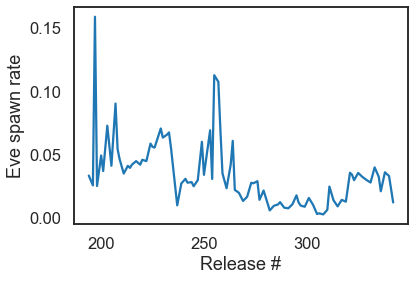

In [14]:
eve_rate = life_df.copy()
eve_rate['is_eve'] = eve_rate['parent'] < 0
eve_rate = eve_rate.groupby('release')['is_eve'].agg(['count', 'sum']).reset_index()
eve_rate = eve_rate.rename(columns={'count': 'n_births', 'sum': 'n_eves'})
eve_rate['eve_rate'] = eve_rate['n_eves']/eve_rate['n_births']

ax = sns.lineplot('release', 'eve_rate', data=eve_rate)
ax.set(xlabel = 'Release #', ylabel = 'Eve spawn rate')

## Build family trees

Helper: Search recursively through lifelogs, starting with Eve

In [15]:
def search_fam(player):
    descendants = parent_df.loc[parent_df['parent'] == player, 'playerID'].values
    
    for d in descendants:
        descendants = np.append(descendants, search_fam(d))
        
    return descendants

Helper: Write data to JSON file

In [16]:
def write_json(data, f):
    with open(f, 'w') as outfile:
        json.dump(data, outfile)

All parent-child pairs:

In [17]:
# All parent-child links
parent_df = life_df[['playerID', 'parent']].copy()
parent_df.head()

,playerID,parent
0,3080130,3080111
1,3080128,3080105
2,3080125,3080101
3,3080122,3080104
4,3080120,3080101


Main loop: Build graphs from parent-child pairs:

In [18]:
families_list = []

for _, family in notebook.tqdm(eves.iterrows(), total=n_eves):

    eve = family['playerID']
    fam_name = family['last']
    fam_start = family['tBirth']
    
    fam_nodes = search_fam(eve)
    fam_df = parent_df[parent_df['playerID'].isin(fam_nodes)]
    fam = nx.from_pandas_edgelist(fam_df, 'parent', 'playerID', None, nx.DiGraph())    
    fam.add_node(str(eve))

    if not len(fam_name):
        fam_name = 'nameless'

    fam_id = 'time-%i_eve-%i_name-%s' % (fam_start, eve, fam_name)

    # Add family to list
    families_list.extend([(relative, fam_id) for relative in fam_nodes + [eve]])

    # Save family data
    out_file = 'outputs/families/families_%s.json' % fam_id
    fam_data = nx.json_graph.node_link_data(fam)
    write_json(fam_data, out_file)

### Tag lifelogs by family
This will be used for several subsequent analyses (e.g., migration, comparing different success measures)

In [19]:
families_df = pd.DataFrame(families_list, columns=['playerID', 'family'])
families_df.to_csv('outputs/family_playerID.tsv', sep='\t')